In [ ]:
import os, copy, glob, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#-------------------
import torch.nn as nn
from torch.optim import Adam
#-------------------
import poseigen_seaside.basics as se
import poseigen_seaside.visuals as viz
import poseigen_compass as co
import poseigen_binmeths as bm
import poseigen_trident.utils as tu
import poseigen_oyster as oys

In [ ]:
mainfolder = se.NewFolder('yy1_data')
fin_bins = se.PickleLoad(mainfolder + 'fin_bins')

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps4')  #3 used epoch sampling with 0.5 as default.      

10


In [4]:
exact_folder = se.NewFolder('Oyster')
exact_iter = 11
pn_RO_exact = se.NewFolder(exact_folder + 'RO_' + str(exact_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

#---------------------------------------------

ne_folder = se.NewFolder('neter')
ne_iter = 11
pn_RO_ne = se.NewFolder(ne_folder + 'RO_' + str(ne_iter))
pn_RO_ne_top = se.NewFolder(pn_RO_ne + 'Top' + str(0))
ne_ranked_can_dict = se.PickleLoad(pn_RO_ne + 'ranked_can_dict')

ne_dict = ne_ranked_can_dict[0]

#---------------------------------------------

allconfigs = {'Exact': exact_dict, 'non-Exact': ne_dict}

In [7]:
yy1_split_transaug = se.PickleLoad(mainfolder + 'yy1_split_transaug')

yy1_max = se.PickleLoad(mainfolder + 'yy1_max')

tri_tpacks = se.PickleLoad(mainfolder + 'tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

In [8]:
masterpseudo = 1e-10

RMS_mode = [tu.MeanExpo, {'expo': 2, 'root': True}]
RMS_mode_pyt = [tu.MeanExpo, {'expo': 2, 'root': True, 'pyt': True}]

bm_args_np = {'byaxis': 1, 'useweights': False, 'seperate': False, 
              'summarize_mode': RMS_mode}

bm_args_pyt = {'byaxis': 1, 'useweights': False, 'seperate': False, 
               'summarize_mode': RMS_mode_pyt, 'pyt': True}

#------------------------------------------------

deverr_args_base = {'expo': 2, 'root': True, 
                    'pseudo': masterpseudo,
                    'scalefactor': yy1_max}

RMSDE_mode_np = [tu.DeviaError, {**deverr_args_base, 'pyt': False}]
RMSDE_mode_pyt = [tu.DeviaError, {**deverr_args_base, 'pyt': True}]  

B_RMSDE_mode_np = [tu.BinnedLoss, {'metrics_mode': RMSDE_mode_np, **bm_args_np}]
B_RMSDE_mode_pyt = [tu.BinnedLoss, {'metrics_mode': RMSDE_mode_pyt, **bm_args_pyt}]

In [9]:
flipo = [[-2, -1], [-2, -1]]

TT_base =  {
    'inps': [d_x1, d_x2], 'out': d_y_ms, 
    'out_std': d_s_rs, 'out_bind': d_b,
    'Split': yy1_split_transaug,   
    'EUS': None, 'obs_weight': None,                    #!@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    'metrics_mode': B_RMSDE_mode_np, 'smallest': True,
    'opt': Adam, 'maxepochs': 100, 
    'patience': 8, 'pickup': True,
    'flips': flipo, 'indivflips': True}

TCS_base = {'trainer': tu.TridentTrainer, 
                 'smallest': None,
                 'get_predictions': True, 'pred_rewrite': False, 
                 'add_pred_args': {'batchsize': 512, 'flips': flipo, 'avg_flips': True},
                 'score_on': 1, 'score_only': False} ### SCORING ON THE EVAL SET, MAKING ONMLY PREDS FOR IT. 

TCR_repeats = 10

TCR_base = {'Splits': None, 'repeats': TCR_repeats,
               'pickup': False, 'savemodels': True, 'returnmodel': True}

#--------------------------------------------------------------------------

es_args = {'out': d_y_ms, 'out_std': d_s_rs, 'out_bind': d_b,
            'split': yy1_split_transaug,
            'metrics_mode': B_RMSDE_mode_np, 
            'score_on': 1,
            'std_cutoff': None, 'ddof': 1, 'top': 3, 'smallest': True}

In [10]:
xp1_trial = 2
xp3_trial = 2
xp5_trial = 2
xp6_trial = 2
xpHIS_trial = 2


xp1_id, xp3_id, xp5_id, xp6_id, xpHIS_id = ['xp' + str(x) + '_' + str(y) 
                                  for x,y in zip([1, 3, 5, 6, 'HIS'], 
                                                 [xp1_trial, xp3_trial, xp5_trial, 
                                                  xp6_trial, xpHIS_trial])]



pn_xp1, pn_xp3, pn_xp5, pn_xp6, pn_xpHIS = [se.NewFolder(xpsfolder + ido) 
                                            for ido in [xp1_id, xp3_id, xp5_id, xp6_id, 
                                                        xpHIS_id]]


In [12]:

import glob, shutil 

def XpsCopy(cur_pn, cur_xp_id, 
            past_xp_id, past_unit, 
            rewrite = False):
                         
    basetargo = cur_pn.replace(cur_xp_id, past_xp_id)[:-2] + str(past_unit) + '/'

    targnames = glob.glob(basetargo + '*')
    lbt = len(basetargo)

    targnames1 = [t for t in targnames if '.p' in t or '.pt' in t]
    newnames1 = [cur_pn + t[lbt:] for t in targnames1]

    print(targnames1, newnames1)


    if rewrite: 
        for n in newnames1: 
            if os.path.isfile(n): os.remove(n)
    for t,n in zip(targnames1, newnames1): 
        if os.path.isfile(n): break #means we already have it
        shutil.copyfile(t, n)

    targnames2 = [t for t in targnames if '.p' not in t and'.pt' not in t]
    newnames2 = [cur_pn + t[lbt:] for t in targnames2]
    if rewrite: 
        for n in newnames2: 
            if os.path.isdir(n): shutil.rmtree(n)
    for t, n in zip(targnames2, newnames2): 
        if os.path.isdir(n): break #means we already have it             
        shutil.copytree(t, n, dirs_exist_ok=True)
    
    print(f'finished copying for {cur_pn}')
    
    return

def XpsBootstrapEnsemb(combs, pathname, rewrite = False):

    iterx = 100

    boots_scores, boots_idxs = [], []

    for icom, com in combs: 
        pn_t = se.NewFolder(pathname + str(icom))

        pn_preds = [pn_t + '0_' + str(ir) + '_Preds' + '.p' ###################
                    for ir in range(TCR_repeats)]
        
        pn_e = pn_t + 'boots_ensemb'

        if os.path.isfile(pn_e + '.p') and rewrite is False: 
            boots_ensemb = se.PickleLoad(pn_e)

        else: 
            boots_ensemb = co.Bootstrapper(pn_preds, mode = [co.EnsembleScorer, es_args],
                                          iters = iterx, updates = 20, return_idx = True)
            se.PickleDump(boots_ensemb, pn_t + 'boots_ensemb')
        
        boots_scores.append(boots_ensemb[0])
        boots_idxs.append(boots_ensemb[1])

        print(f'---- Finished {icom} ----')
    
    return np.array(boots_scores), np.array(boots_idxs)

def XpsResults(pn_xp, xp_combs,
               icof_only = None,
               ref_ic = 0, rewrite = False): 
    
    pf_args = {'mode1': [se.RelativeChange, {'perc': True}]}

    bs_all = []
    bs_all_r2r = []

    for icof, (cof_name, cof) in enumerate(allconfigs.items()):

        if icof_only is not None: 
            if icof not in icof_only: continue 
                            
        pn_t1 = se.NewFolder(pn_xp + str(icof))

        boots_scores = XpsBootstrapEnsemb(xp_combs, pn_t1, rewrite = rewrite)[0] # Just get scores 

        bs_all.append(boots_scores)

        com = boots_scores[ref_ic]

        rel2refs = [se.PairwiseFuncer(boots_scores[ic], com, **pf_args) for ic, c in xp_combs]

        bs_all_r2r.append(rel2refs)

        print(f'**** Finished {icof} ****')
                    
    bs_all = np.stack(bs_all)
    se.PickleDump(bs_all, pn_xp + 'bs_all')

    bs_all_r2r = np.stack(bs_all_r2r)
    se.PickleDump(bs_all_r2r, pn_xp + 'bs_all_r2r' + '_' + str(ref_ic))

    return bs_all, bs_all_r2r

def XpsTables(pn_xp, xp_combs, xp_variables, ber2rs, icof_only = None):
    
    onesided = None
    conf_alpha = 0.90

    print(ber2rs.shape)

    ber2rs = ber2rs[:, :, :, 2] ####################################

    ber2rs_mean = np.mean(ber2rs, axis = -1)
    ber2rs_se = np.std(ber2rs, axis = -1)
    ber2rs_low, ber2rs_high = co.BootstrapConfidenceInterval(ber2rs, alpha = conf_alpha, onesided=onesided, axis = -1)

    def sigo(low, high): 
        if onesided == 'lesser': sigi = 0 > high
        if onesided == 'greater': sigi = low > 0 
        if onesided == None: sigi = np.logical_or(0 > high, low > 0)
        return sigi
    
    ber2rs_sigo = sigo(ber2rs_low, ber2rs_high)

    #################################################

    per = pd.DataFrame(ber2rs_mean).T

    if len(xp_variables) > 1: 
        # per.index = pd.MultiIndex.from_tuples([tuple(x[1]) for x in cur_combs], names=cur_variables)
        per.index = [tuple(x[1]) for x in xp_combs]
        per.index.names = ['Combination']
    else: 
        per.index = [x[1][0] for x in xp_combs]
        per.index.names = xp_variables
    
    if len(xp_combs[0][1]) > 1: 
        multcolx = pd.MultiIndex.from_tuples([tuple(g[1]) for g in xp_combs])
    else: multcolx = [str(g[1][0]) for g in xp_combs]
    
    configos = list(allconfigs.keys())
    if icof_only is not None: configos = [cz for icz, cz in enumerate(configos) if icz in icof_only]

    per.columns = configos

    per_style = per.style.format(precision=1).background_gradient(axis = 1, vmin = -25, vmax = 0, cmap = 'Greys_r')


    per_style = per_style.apply(lambda _: 
                                np.where(ber2rs_sigo.reshape(-1, len(multcolx)).T, 
                                         'font-weight: bold', ''),
                                           axis = None)
        
    # #################################################

    ber2rs_stats = np.stack([ber2rs_mean, ber2rs_se, ber2rs_low, ber2rs_high, ber2rs_sigo], axis = -1)

    ber2rs_stats_tidy = [[co, ic, *c, *ber2rs_stats[ico, ic]]
                        for ico, co in enumerate(configos)
                        for ic, c in xp_combs]

    tups_data = [('Models', '', '')]

    tups_var = [*[('Unit', 'Subject',x) for x in ['ID'] + xp_variables]]

    tups_stand = [('Stat', 'Mean', ''), ('Stat', 'SE', ''),
                  ('Stat', 'Percentile', '5th'), ('Stat', 'Percentile', '95th'),
                  ('Stat', 'Percentile', 'Sig.')]

    tups_all = [*tups_data, *tups_var, *tups_stand]

    pdx = pd.DataFrame(ber2rs_stats_tidy)
    multcol = pd.MultiIndex.from_tuples(tups_all)
    pdx.columns = multcol

    pdx[('Stat', 'Percentile', 'Sig.')] = pdx[('Stat', 'Percentile', 'Sig.')].astype('bool')

    def boldo(x): 
            if x[('Stat', 'Percentile', 'Sig.')] == True: 
                return ['font-weight: bold'] * len(x) 
            else: return [''] * len(x)

    pdx = pdx.sort_values([('Models', '', ''), ('Unit', 'Subject', 'ID')])

    pdx_style = pdx.style.format(precision=4).apply(boldo, axis = 1).background_gradient(axis = 1, 
                                                                                         vmin = -25, vmax = 0, 
                                                                                         subset = [('Stat', 'Mean', '')], 
                                                                                         cmap = 'Greys_r')

    return per, per_style, pdx, pdx_style

In [ ]:
modo = oys.DualOyster
duds_mode = [oys.Reset_DualOyster, {}]

# xp1: BinLoss

In [13]:
pn_xp1 = se.NewFolder(xpsfolder + 'xp1' + '_' + str(xp1_trial))

xp1_variables = ['Loss Func.']

lossos = ['RMSDE', 'RBR-D']

xp1_combs = [[lo] for lo in lossos]

xp1_combs = [[ic, c] for ic,c in enumerate(xp1_combs)]
xp1_combs

[[0, ['RMSDE']], [1, ['RBR-D']]]

In [ ]:
for icof, (cof_name, cof) in enumerate(allconfigs.items()):

    for icom, com in xp1_combs:

        pn_t1 = se.NewFolder(pn_xp1 + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        los = com[0]

        lmo, lbx = (RMSDE_mode_pyt, False) if los == 'RMSDE' else (B_RMSDE_mode_pyt, True)

        xp1_TT_args = {'duds_mode': duds_mode, 'duds': TCR_repeats,
                       'loss_mode': lmo, 'loss_bind': lbx, **TT_base}

        xp1_TCS_args = {'trainer_args': xp1_TT_args, **TCS_base}

        xp1_TCR_args = {**xp1_TCS_args, **TCR_base, 'pathname': pn_t2}

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp1_TCR_args)

 Cross val 1 of 1, Repeat 1 of 10
6.974653338932121
 Cross val 1 of 1, Repeat 2 of 10
6.715997862610587
 Cross val 1 of 1, Repeat 3 of 10
10.863584122173355
 Cross val 1 of 1, Repeat 4 of 10
6.735814098953554
 Cross val 1 of 1, Repeat 5 of 10
6.855229153520028
 Cross val 1 of 1, Repeat 6 of 10
7.053487980763034
 Cross val 1 of 1, Repeat 7 of 10
7.08622826423962
 Cross val 1 of 1, Repeat 8 of 10
5.141916090725438
 Cross val 1 of 1, Repeat 9 of 10
7.17192768113252
 Cross val 1 of 1, Repeat 10 of 10
6.119103004988633
Best Score 5.141916090725438 at Cross val 1 of 1 and Repeat 8 of 10
The pathname is: ./xps4/xp1_2/0/0//0_7_Mod.pt
 Cross val 1 of 1, Repeat 1 of 10
E 1 Training: nan Validation: 17.21394118527432 Counter 0
E 2 Training: nan Validation: 14.098569478221005 Counter 0
E 3 Training: nan Validation: 11.376069075020972 Counter 0
E 4 Training: nan Validation: 11.438223619379613 Counter 1
E 5 Training: nan Validation: 15.573403670615164 Counter 2
E 6 Training: nan Validation: 10.05837

In [ ]:
xp1_bs_all, xp1_bs_r2r_all = XpsResults(pn_xp1, xp1_combs, ref_ic = 0, rewrite = False)

In [16]:
xp1_tabs = XpsTables(pn_xp1, xp1_combs, xp1_variables, xp1_bs_r2r_all)

xp1_tab_main, xp1_tab_main_sty, xp1_tab_extra, xp1_tab_extra_sty = xp1_tabs

xp1_tab_main_sty

(2, 2, 10000, 4)


,Exact,non-Exact
Loss Func.,,
RMSDE,0.4,0.5
RBR-D,-19.9,0.0


In [17]:
xp1_tab_extra_sty

# xp3 

In [14]:
weighttypes = ['DW','RBW']

newrange = True
traino = yy1_split_transaug[0]
shx_args = {'onlyidx': traino, 'newrange': True}
mino = False #ONLY RECIP

yy1_weights = {} 

for wt in weighttypes:
    if wt == weighttypes[0]:
        yy1_weights[wt] = se.DenseWeighter(d_y_ms, alpha = 1.0, multi = False, 
                                        **shx_args)
    else: 
        yy1_weights[wt] = bm.BinWeighter(d_b,
                                      byaxis = None, uni = None, 
                                      minus = mino, dtype = np.float32, 
                                      **shx_args)
        
se. PickleDump(yy1_weights, mainfolder + 'yy1_weights')

yy1_weights = se.PickleLoad(mainfolder + 'yy1_weights')

# plt.scatter(*[x.reshape(-1)[::10] for x in [d_b, yy1_weights['RBW']]])

In [18]:
pn_xp3 = se.NewFolder(xpsfolder + 'xp3' + '_' + str(xp3_trial))

xp3_variables = ['Weighting']

binweis = ['None', 'DenseW', 'Recip.']
xp3_combs = []

for bw in binweis: xp3_combs.append([bw])

xp3_combs = [[ic, c] for ic,c in enumerate(xp3_combs)]
xp3_combs

[[0, ['None']], [1, ['DenseW']], [2, ['Recip.']]]

In [ ]:
xp3_rewrite = False

lmo, lbx = RMSDE_mode_pyt, False

for icof, (cof_name, cof) in enumerate(allconfigs.items()):

    for icom, com in xp3_combs:

        pn_t1 = se.NewFolder(pn_xp3 + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        bw = com[0]

        #---------------------------------------

        par_xp, par_unit = None, None

        if bw == 'None': par_xp, par_unit = xp1_id, 0

        if par_unit is not None: 
            XpsCopy(cur_pn = pn_t2, cur_xp_id = xp3_id, 
                    past_xp_id = par_xp, past_unit = par_unit, 
                    rewrite = xp3_rewrite)
        
        #---------------------------------------
       
        if bw != binweis[0]:
            
            print('WEIGHTING')

            if bw == binweis[1]: DW = yy1_weights[weighttypes[0]]
            elif bw == binweis[2]: DW = yy1_weights[weighttypes[1]]
        
        else: DW = None

        #---------------------------------------
                

        xp3_TT_args = {'out_weights': DW, 
                        'duds_mode': duds_mode, 'duds': TCR_repeats,
                       'loss_mode': lmo, 'loss_bind': lbx, **TT_base}

        xp3_TCS_args = {'trainer_args': xp3_TT_args, **TCS_base}

        xp3_TCR_args = {**xp3_TCS_args, **TCR_base, 'pathname': pn_t2}

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp3_TCR_args)

['./xps4/xp1_2/0/0/0_0_Met.p', './xps4/xp1_2/0/0/0_0_Mod.pt', './xps4/xp1_2/0/0/0_0_Preds.p', './xps4/xp1_2/0/0/0_10_Met.p', './xps4/xp1_2/0/0/0_10_Mod.pt', './xps4/xp1_2/0/0/0_10_Preds.p', './xps4/xp1_2/0/0/0_11_Met.p', './xps4/xp1_2/0/0/0_11_Mod.pt', './xps4/xp1_2/0/0/0_1_Met.p', './xps4/xp1_2/0/0/0_1_Mod.pt', './xps4/xp1_2/0/0/0_1_Preds.p', './xps4/xp1_2/0/0/0_2_Met.p', './xps4/xp1_2/0/0/0_2_Mod.pt', './xps4/xp1_2/0/0/0_2_Preds.p', './xps4/xp1_2/0/0/0_3_Met.p', './xps4/xp1_2/0/0/0_3_Mod.pt', './xps4/xp1_2/0/0/0_3_Preds.p', './xps4/xp1_2/0/0/0_4_Met.p', './xps4/xp1_2/0/0/0_4_Mod.pt', './xps4/xp1_2/0/0/0_4_Preds.p', './xps4/xp1_2/0/0/0_5_Met.p', './xps4/xp1_2/0/0/0_5_Mod.pt', './xps4/xp1_2/0/0/0_5_Preds.p', './xps4/xp1_2/0/0/0_6_Met.p', './xps4/xp1_2/0/0/0_6_Mod.pt', './xps4/xp1_2/0/0/0_6_Preds.p', './xps4/xp1_2/0/0/0_7_Met.p', './xps4/xp1_2/0/0/0_7_Mod.pt', './xps4/xp1_2/0/0/0_7_Preds.p', './xps4/xp1_2/0/0/0_8_Met.p', './xps4/xp1_2/0/0/0_8_Mod.pt', './xps4/xp1_2/0/0/0_8_Preds.p', './

In [20]:
xp3_bs_all, xp3_bs_r2r_all = XpsResults(pn_xp3, xp3_combs, ref_ic = 0, rewrite = False)

---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
**** Finished 0 ****
---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
**** Finished 1 ****


In [22]:
xp3_tabs = XpsTables(pn_xp3, xp3_combs, xp3_variables, xp3_bs_r2r_all)

xp3_tab_main, xp3_tab_main_sty, xp3_tab_extra, xp3_tab_extra_sty = xp3_tabs

xp3_tab_main_sty

(2, 3, 10000, 4)


,Exact,non-Exact
Weighting,,
None,0.4,0.5
DenseW,-0.5,-16.5
Recip.,-26.4,6.2


In [23]:
xp3_tab_extra_sty

# xp5

In [24]:
us_props = ['None'] + [0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.01]
print(us_props)

['None', 0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.01]


In [25]:
pn_xp5 = se.NewFolder(xpsfolder + xp5_id)

xp5_variables = ['Sampling Prop.'] 

xp5_combs = []
for us in us_props: xp5_combs.append([us])
    
xp5_combs = [[ic, c] for ic,c in enumerate(xp5_combs)]
xp5_combs

[[0, ['None']],
 [1, [0.8]],
 [2, [0.4]],
 [3, [0.2]],
 [4, [0.1]],
 [5, [0.05]],
 [6, [0.025]],
 [7, [0.01]]]

In [ ]:
xp5_rewrite = True

lmo, lbx = RMSDE_mode_pyt, False

for icof, (cof_name, cof) in enumerate(allconfigs.items()):

    for icom, com in xp5_combs:

        pn_t1 = se.NewFolder(pn_xp5 + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        us = com[0]

        #---------------------------------------

        par_xp, par_unit = None, None

        if us == 'None': par_xp, par_unit = xp1_id, 0

        if par_unit is not None: 
            XpsCopy(cur_pn = pn_t2, cur_xp_id = xp5_id, 
                    past_xp_id = par_xp, past_unit = par_unit, 
                    rewrite = xp5_rewrite)
        
        #--------------------------------------- 
        
        if us == 'None': us = None           

        xp5_TT_args = {'out_weights': None,  
                        'duds_mode': duds_mode, 'duds': TCR_repeats,
                       'loss_mode': lmo, 'loss_bind': lbx, **TT_base}
        
        xp5_TT_args.update({'EUS': us, 'obs_weight': d_b.reshape(-1)})

        xp5_TCS_args = {'trainer_args': xp5_TT_args, **TCS_base}

        xp5_TCR_args = {**xp5_TCS_args, **TCR_base, 'pathname': pn_t2}

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp5_TCR_args)

['./xps4/xp1_2/0/0/0_0_Met.p', './xps4/xp1_2/0/0/0_0_Mod.pt', './xps4/xp1_2/0/0/0_0_Preds.p', './xps4/xp1_2/0/0/0_10_Met.p', './xps4/xp1_2/0/0/0_10_Mod.pt', './xps4/xp1_2/0/0/0_10_Preds.p', './xps4/xp1_2/0/0/0_11_Met.p', './xps4/xp1_2/0/0/0_11_Mod.pt', './xps4/xp1_2/0/0/0_1_Met.p', './xps4/xp1_2/0/0/0_1_Mod.pt', './xps4/xp1_2/0/0/0_1_Preds.p', './xps4/xp1_2/0/0/0_2_Met.p', './xps4/xp1_2/0/0/0_2_Mod.pt', './xps4/xp1_2/0/0/0_2_Preds.p', './xps4/xp1_2/0/0/0_3_Met.p', './xps4/xp1_2/0/0/0_3_Mod.pt', './xps4/xp1_2/0/0/0_3_Preds.p', './xps4/xp1_2/0/0/0_4_Met.p', './xps4/xp1_2/0/0/0_4_Mod.pt', './xps4/xp1_2/0/0/0_4_Preds.p', './xps4/xp1_2/0/0/0_5_Met.p', './xps4/xp1_2/0/0/0_5_Mod.pt', './xps4/xp1_2/0/0/0_5_Preds.p', './xps4/xp1_2/0/0/0_6_Met.p', './xps4/xp1_2/0/0/0_6_Mod.pt', './xps4/xp1_2/0/0/0_6_Preds.p', './xps4/xp1_2/0/0/0_7_Met.p', './xps4/xp1_2/0/0/0_7_Mod.pt', './xps4/xp1_2/0/0/0_7_Preds.p', './xps4/xp1_2/0/0/0_8_Met.p', './xps4/xp1_2/0/0/0_8_Mod.pt', './xps4/xp1_2/0/0/0_8_Preds.p', './

In [26]:
xp5_bs_all, xp5_bs_r2r_all = XpsResults(pn_xp5, xp5_combs, ref_ic = 0, rewrite = False)

---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
---- Finished 5 ----
---- Finished 6 ----
---- Finished 7 ----
**** Finished 0 ****
---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
---- Finished 5 ----
---- Finished 6 ----
---- Finished 7 ----
**** Finished 1 ****


In [28]:
xp5_tabs = XpsTables(pn_xp5, xp5_combs, xp5_variables, xp5_bs_r2r_all)

xp5_tab_main, xp5_tab_main_sty, xp5_tab_extra, xp5_tab_extra_sty = xp5_tabs

xp5_tab_main_sty

(2, 8, 10000, 4)


,Exact,non-Exact
Sampling Prop.,,
None,0.4,0.5
0.800000,-17.0,-10.0
0.400000,-22.9,-9.4
0.200000,-27.0,-9.6
0.100000,-22.0,-15.9
0.050000,15.4,-18.4
0.025000,0.9,-15.1
0.010000,5.7,32.1


In [29]:
xp5_tab_extra_sty

# xp6: Combinations

In [30]:
pn_xp6 = se.NewFolder(xpsfolder + xp6_id)

xp6_variables = ['Loss Function', 'Weighting', 'Sampling']

top_lf = ['RMSDE', 'RBR-D']
top_weis = ['None', 'Recip.']
top_us = [False, True]

xp6_combs = []

for los in top_lf: 

    for bw in top_weis: 
        
        for us in top_us:
        
            xp6_combs.append([los, bw, us])

xp6_combs = [[ic, c] for ic,c in enumerate(xp6_combs)]
xp6_combs

[[0, ['RMSDE', 'None', False]],
 [1, ['RMSDE', 'None', True]],
 [2, ['RMSDE', 'Recip.', False]],
 [3, ['RMSDE', 'Recip.', True]],
 [4, ['RBR-D', 'None', False]],
 [5, ['RBR-D', 'None', True]],
 [6, ['RBR-D', 'Recip.', False]],
 [7, ['RBR-D', 'Recip.', True]]]

In [ ]:
xp6_rewrite = True

lmo, lbx = RMSDE_mode_pyt, False

for icof, (cof_name, cof) in enumerate(allconfigs.items()):

    for icom, com in xp6_combs:

        pn_t1 = se.NewFolder(pn_xp6 + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        print(icof, icom)

        los, bw, us = com

        #---------------------------------------

        par_xp, par_unit = None, None

        if icom == 0: par_xp, par_unit = xp1_id, 0

        if icom == 1: 
            if icof == 0: par_xp, par_unit = xp5_id, 3 # EUS 0.2
            if icof == 1: par_xp, par_unit = xp5_id, 5 # EUS 0.05
            
        if icom == 2: par_xp, par_unit = xp3_id, 2 # RECIP
        if icom == 4: par_xp, par_unit = xp1_id, 1 # RBR

        print(par_xp, par_unit)

        if par_unit is not None: 
            XpsCopy(cur_pn = pn_t2, cur_xp_id = xp6_id, 
                    past_xp_id = par_xp, past_unit = par_unit, 
                    rewrite = xp6_rewrite)
        
        #---------------------------------------

        lmo, lbx = (RMSDE_mode_pyt, False) if los == 'RMSDE' else (B_RMSDE_mode_pyt, True)

        sampweimode = None 
        if bw != top_weis[0]:
            sampweimode = [bm.BinWeighter, {'uni': np.arange(fin_bins), 'byaxis': None, 
                                            'minus': False, 'newrange': True}]

      
        if us:
        
            if icof == 0: usxo = 0.2
            if icof == 1: usxo = 0.05

        else: 
            
            usxo = None
        
        print(usxo)
        
        #---------------------------------------
        
        xp6_TT_args = {'duds_mode': duds_mode, 'duds': TCR_repeats,
                       'loss_mode': lmo, 'loss_bind': lbx,
                       'weights_mode': sampweimode, 'weights_bind': True,          
                       **TT_base}
        
        xp6_TT_args.update({'EUS': usxo, 'obs_weight': d_b.reshape(-1)})
        
        xp6_TCS_args = {'trainer_args': xp6_TT_args, **TCS_base}

        xp6_TCR_args = {**xp6_TCS_args, **TCR_base, 'pathname': pn_t2}

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xp6_TCR_args)

0 0
xp1_2 0
['./xps4/xp1_2/0/0/0_0_Met.p', './xps4/xp1_2/0/0/0_0_Mod.pt', './xps4/xp1_2/0/0/0_0_Preds.p', './xps4/xp1_2/0/0/0_10_Met.p', './xps4/xp1_2/0/0/0_10_Mod.pt', './xps4/xp1_2/0/0/0_10_Preds.p', './xps4/xp1_2/0/0/0_11_Met.p', './xps4/xp1_2/0/0/0_11_Mod.pt', './xps4/xp1_2/0/0/0_1_Met.p', './xps4/xp1_2/0/0/0_1_Mod.pt', './xps4/xp1_2/0/0/0_1_Preds.p', './xps4/xp1_2/0/0/0_2_Met.p', './xps4/xp1_2/0/0/0_2_Mod.pt', './xps4/xp1_2/0/0/0_2_Preds.p', './xps4/xp1_2/0/0/0_3_Met.p', './xps4/xp1_2/0/0/0_3_Mod.pt', './xps4/xp1_2/0/0/0_3_Preds.p', './xps4/xp1_2/0/0/0_4_Met.p', './xps4/xp1_2/0/0/0_4_Mod.pt', './xps4/xp1_2/0/0/0_4_Preds.p', './xps4/xp1_2/0/0/0_5_Met.p', './xps4/xp1_2/0/0/0_5_Mod.pt', './xps4/xp1_2/0/0/0_5_Preds.p', './xps4/xp1_2/0/0/0_6_Met.p', './xps4/xp1_2/0/0/0_6_Mod.pt', './xps4/xp1_2/0/0/0_6_Preds.p', './xps4/xp1_2/0/0/0_7_Met.p', './xps4/xp1_2/0/0/0_7_Mod.pt', './xps4/xp1_2/0/0/0_7_Preds.p', './xps4/xp1_2/0/0/0_8_Met.p', './xps4/xp1_2/0/0/0_8_Mod.pt', './xps4/xp1_2/0/0/0_8_P

In [31]:
xp6_bs_all, xp6_bs_r2r_all = XpsResults(pn_xp6, xp6_combs, ref_ic = 0, rewrite = False)

---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
---- Finished 5 ----
---- Finished 6 ----
---- Finished 7 ----
**** Finished 0 ****
---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
---- Finished 5 ----
---- Finished 6 ----
---- Finished 7 ----
**** Finished 1 ****


In [32]:
xp6_tabs = XpsTables(pn_xp6, xp6_combs, xp6_variables, xp6_bs_r2r_all)

xp6_tab_main, xp6_tab_main_sty, xp6_tab_extra, xp6_tab_extra_sty = xp6_tabs

xp6_tab_main_sty

(2, 8, 10000, 4)


,Exact,non-Exact
Combination,,
"('RMSDE', 'None', False)",0.4,0.5
"('RMSDE', 'None', True)",-27.0,-18.4
"('RMSDE', 'Recip.', False)",-26.4,6.2
"('RMSDE', 'Recip.', True)",-35.3,-21.9
"('RBR-D', 'None', False)",-19.9,0.0
"('RBR-D', 'None', True)",-35.0,-25.0
"('RBR-D', 'Recip.', False)",-5.5,41.3
"('RBR-D', 'Recip.', True)",-33.5,-24.5


In [33]:
xp6_tab_extra_sty

### Comparing Configs

In [34]:
def CompareConfigs_Scores(xp_bse, ref = 0):

    #compares configs by scores array of (configs, xp units, scores, sets)
    #compares configs to a reference config 

    pf_args = {'mode1': [se.RelativeChange, {'perc': True}]}

    boots_rel2ref = [[se.PairwiseFuncer(co, c[ref], **pf_args) for co in c] 
                     for c in np.swapaxes(xp_bse, 0, 1)]
    
    return np.swapaxes(np.array(boots_rel2ref), 0, 1)


xp6_cc = CompareConfigs_Scores(xp6_bs_all)

cc_tab_main, cc_tab_main_sty, cc_tab_extra_main, cc_tab_extra_main_sty = XpsTables(pn_xp6, xp6_combs, xp6_variables, xp6_cc)

# xp6_cc_tab_main_sty

(2, 8, 10000, 4)


In [35]:
bests = list(xp6_tab_main.apply(np.argmin, axis=0))
print(bests)

xp6_bse_bests = np.stack([co[b] for co, b in zip(xp6_bs_all, bests)])

xp6_snb = np.stack([xp6_bse_bests], axis = 1) #np.stack([xp6_bse_stands, xp6_bse_bests], axis = 1)

snb_combs = [[n, [x]] for n, x in enumerate(['Best'])] # ['Standard', 'Best']
snb_variables = ['Method']

xp6_snb_cc = CompareConfigs_Scores(xp6_snb)

snb_tab_main, snb_tab_main_sty, snb_tab_extra, snb_tab_extra_sty = XpsTables(pn_xp6, snb_combs, snb_variables, xp6_snb_cc)

snb_tab_main_sty

[3, 5]
(2, 1, 10000, 4)


,Exact,non-Exact
Method,,
Best,0.1,-0.2


In [36]:
snb_tab_extra_sty

## Final Performance

In [16]:
pn_xpF, icof, icom = pn_xp6, 0, 3

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' 
                  for ir in range(TCR_repeats)]

#-----------------------------------------------------

_ = co.EnsembleScorer(ex_pn_preds, **es_args,
                   pathname = pn_t2, return_extra = False)

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')
print(ex_ens_idx)

ex_ens_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' for ir in ex_ens_idx] 
ex_ens_preds = np.stack([se.PickleLoad(p) for p in ex_ens_pn_preds]).mean(0)

[6 4 9]


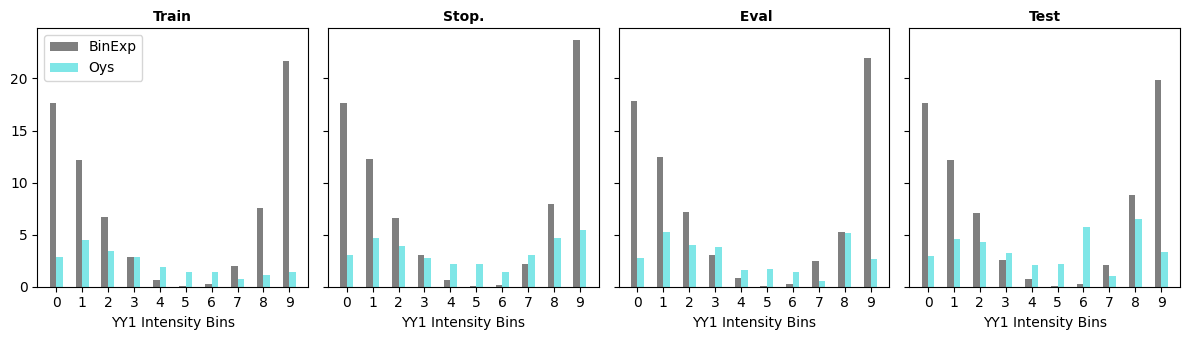

In [ ]:
divset = ['Train', 'Stop.', ' Eval', 'Test']

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

#----------------------------------------------------

splix = yy1_split_transaug[0]

d_y_ms_bind = [d_y_ms[splix][d_b[splix] == i] for i in np.arange(fin_bins)]
d_y_ms_bind_mean = [np.mean(d, keepdims= True) for d in d_y_ms_bind]
d_y_ms_mom = np.mean(d_y_ms_bind_mean)
d_y_ms_mom_xpa = np.repeat(d_y_ms_mom, d_y_ms.shape[0]).reshape(d_y_ms.shape)

#--------------------------------------------------------


BM_args = {'metrics_mode': RMSDE_mode_np, 'summarize_mode': None}

mom_BM = np.array([tu.BinnedLoss(d_y_ms_mom_xpa[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

ex_ens_BM = np.array([tu.BinnedLoss(ex_ens_preds[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])


comb_BM = np.concatenate([mom_BM, ex_ens_BM], axis = 1) 

comb_BM_red = [[np.arange(fin_bins), comb_BM[io]] for io in np.arange(len(yy1_split_transaug))]

bp_args = {'xlabel': 'YY1 Intensity Bins',
            'labelheight': False, 'alpha': 0.5, 
            'group': ['BinExp', 'Oys', 'Bas'], 'color': ['black', 'darkturquoise'], 
            'width': 0.25}

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

viz.MultiPlot(comb_BM_red, **mp_args,  
          plt_mode = [viz.BarPlot, bp_args], 
          indiv_args = {'legend': [True, False, False, False]});

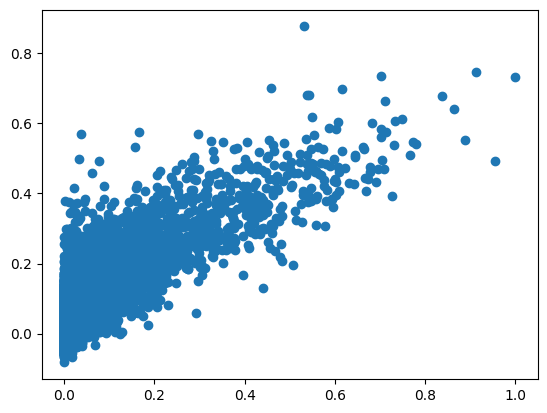

In [19]:
plt.scatter(*[x.reshape(-1) for x in [d_y_ms, ex_ens_preds]])